# News Search TL;DR using Langgraph (Too Long Didn't Read)

## Overview
This project demonstrates the creation of a news summarization agent uses large language models (LLMs) for decision making and summarization as well as a news API calls. The integration of LangGraph to coordinate sequential and cyclical processes, open-ai to choose and condense articles, newsAPI to retrieve relevant article metadata, and BeautifulSoup for web scraping allows for the generation of relevant current event article TL;DRs from a single query.

## Motivation
Although LLMs demonstrate excellent conversational and educational ability, they lack access to knowledge of current events. This project allow users to ask about a news topic they are interested and receive a TL;DR of relevant articles. The goal is to allow users to conveniently follow their interest and stay current with their connection to world events.

## Key Components
1. **LangGraph**: Orchestrates the overall workflow, managing the flow of data between different stages of the process.
2. **GPT-4o-mini (via LangChain)**: Generates search terms, selects relevant articles, parses html, provides article summaries
3. **NewsAPI**: Retrieves article metadata from keyword search
4. **BeautifulSoup**: Retrieves html from page
5. **Asyncio**: Allows separate LLM calls to be made concurrently for speed efficiency.

## Method
The news research follows these high-level steps:

1. **NewsAPI Parameter Creation (LLM 1)**: Given a user query, the model generates a formatted parameter dict for the news search.

2. **Article Metadata Retrieval**: An API call to NewsAPI retrieves relevant article metadata.

3. **Article Text Retrieval**: Beautiful Soup scrapes the full article text from the urls to ensure validity.

4. **Conditional Logic**: Conditional logic either: repeats 1-3 if article threshold not reached, proceeds to step 5, end with no articles found.

5. **Relevant Article Selection (LLM 2)**: The model selects urls from the most relevant n-articles for the user query based on the short synopsis provided by the API.

6. **Generate TL;DR (LLM 3+)**: A summarized set of bullet points for each article is generated concurrently with Asyncio.

This workflow is managed by LangGraph to make sure that the appropriate prompt is fed to the each LLM call.

## Conclusion
This news TL;DR agent highlights the utility of coordinating successive LLM generations in order to
achieve a higher level goal.

Although the current implementation only retrieves bulleted summaries, it could be elaborated to start
a dialogue with the user that could allow them to ask questions about the article and get 
more information or to collectively generate a coherent opinion.

## Setup and Imports

Import necessary libraries

In [448]:
import os
from typing import TypedDict, Annotated, List
from langgraph.graph import Graph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod
from datetime import datetime
import re

from getpass import getpass
from dotenv import load_dotenv

from newsapi import NewsApiClient
import requests
from bs4 import BeautifulSoup

from IPython.display import display, Image as IPImage
import asyncio

## Get an NewsAPI Key
* create a free developer account at https://newsapi.org/
* 100 requests per day
* articles between 1 day and 1 month old

## Setup LLM Model
* create an account and register a credit card at https://platform.openai.com/chat-completions
* create an API key

## Create Your Environment (Optional)
Create a file named .env in the same directory as this notebook with the following
```
OPENAI_API_KEY = 'your-api-key'
NEWSAPI_KEY = 'your-api-key'
```

If you skip this step, you will be asked to input all API keys once each time you start this notebook.

## Initialize Model and Environmental Variables

If you're not running a local model with Ollama, the next cell will ask for your OPENAI_API_KEY and
securely add it as an environmental variable. It will not persist in this notebook.

In [449]:
# check for .env file
if os.path.exists(".env"):
    load_dotenv()
else:
    # ask for API keys
    os.environ["NEWSAPI_KEY"] = getpass("Enter your News API key: ")
    os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API key: ")

# sets the OpenAI model to use and initialize model
model = "gpt-4o-mini"
llm = ChatOpenAI(model=model)

## Test APIs

In [450]:
llm.invoke("Why is the sky blue?").content

"The sky appears blue primarily due to a phenomenon called Rayleigh scattering. When sunlight enters the Earth's atmosphere, it is made up of various colors of light, which correspond to different wavelengths. Blue light has a shorter wavelength and is scattered in all directions by the gases and particles in the atmosphere more effectively than other colors with longer wavelengths, such as red or yellow.\n\nDuring the day, when the sun is high in the sky, this scattered blue light is what we see when we look up. The scattering effect is stronger when the sun is lower in the sky, such as during sunrise or sunset, which is why the sky can appear more red or orange at those times, as the light passes through a thicker layer of the atmosphere.\n\nIn summary, the blue color of the sky is due to the scattering of sunlight by the atmosphere, with blue light being scattered more than other colors."

In [451]:
newsapi = NewsApiClient(api_key=os.getenv('NEWSAPI_KEY'))

query = 'bitcoin price'

all_articles = newsapi.get_everything(q=query,
                                      sources='cnn',
                                      domains='bbc.co.uk,techcrunch.com',
                                      language='en',
                                      sort_by='relevancy',)


all_articles['articles'][0]

{'source': {'id': 'cnn', 'name': 'CNN'},
 'author': 'Krystal Hur',
 'title': 'What fueled this week’s record-breaking stock rally | CNN Business',
 'description': 'The stock market is racking up record highs again. Investors are wasting no time moving into riskier assets from bitcoin to tech stocks after last week’s long-awaited rate cut from the Federal Reserve.',
 'url': 'https://www.cnn.com/2024/09/27/investing/stocks-records-pce-fed/index.html',
 'urlToImage': 'https://media.cnn.com/api/v1/images/stellar/prod/gettyimages-2173210136-copy.jpg?c=16x9&q=w_800,c_fill',
 'publishedAt': '2024-09-27T16:31:21Z',
 'content': 'The stock market is racking up record highs again. Investors are wasting no time moving into riskier assets from bitcoin to tech stocks after last weeks long-awaited rate cut from the Federal Reserve… [+3533 chars]'}

## Define Data Structures

Define the GraphState class. Each user query will be added to a new instance of this class, which will be passed
through the LangGraph structure while collect outputs from each step. When it reaches the END node, it's final
result will be returned to the user.

In [452]:
class GraphState(TypedDict):
    news_query: Annotated[str, "Input query to extract news search parameters from."]
    num_searches_remaining: Annotated[int, "Number of articles to search for."]
    newsapi_params: Annotated[dict, "Structured argument for the News API."]
    past_searches: Annotated[List[dict], "List of search params already used."]
    articles_metadata: Annotated[list[dict], "Article metadata response from the News API"]
    scraped_urls: Annotated[List[str], "List of urls already scraped."]
    num_articles_tldr: Annotated[int, "Number of articles to create TL;DR for."]
    potential_articles: Annotated[List[dict[str, str, str]], "Article with full text to consider summarizing."]
    tldr_articles: Annotated[List[dict[str, str, str]], "Selected article TL;DRs."]
    formatted_results: Annotated[str, "Formatted results to display."]

## Define NewsAPI argument data structure with Pydantic
* the model will create a formatted dictionary of params for the NewsAPI call
* the NewsApiParams class inherits from the Pydantic BaseModel
* Langchain will parse and feed paramd descriptions to the LLM

In [453]:
class NewsApiParams(BaseModel):
    q: str = Field(description="1-3 concise keyword search terms that are not too specific")
    sources: str =Field(description="comma-separated list of sources from: 'abc-news,abc-news-au,associated-press,australian-financial-review,axios,bbc-news,bbc-sport,bloomberg,business-insider,cbc-news,cbs-news,cnn,financial-post,fortune'")
    from_param: str = Field(description="date in format 'YYYY-MM-DD' Two days ago minimum. Extend up to 30 days on second and subsequent requests.")
    to: str = Field(description="date in format 'YYYY-MM-DD' today's date unless specified")
    language: str = Field(description="language of articles 'en' unless specified one of ['ar', 'de', 'en', 'es', 'fr', 'he', 'it', 'nl', 'no', 'pt', 'ru', 'se', 'ud', 'zh']")
    sort_by: str = Field(description="sort by 'relevancy', 'popularity', or 'publishedAt'")

## Define Graph Functions

Define the functions (nodes) that will be used in the LangGraph workflow.

In [454]:
def generate_newsapi_params(state: GraphState) -> GraphState:
    """Based on the query, generate News API params."""
    # initialize parser to define the structure of the response
    parser = JsonOutputParser(pydantic_object=NewsApiParams)

    # retrieve today's date
    today_date = datetime.now().strftime("%Y-%m-%d")

    # retrieve list of past search params
    past_searches = state["past_searches"]

    # retrieve number of searches remaining
    num_searches_remaining = state["num_searches_remaining"]

    # retrieve the user's query
    news_query = state["news_query"]

    template = """
    Today is {today_date}.

    Create a param dict for the News API based on the user query:
    {query}

    These searches have already been made. Loosen the search terms to get more results.
    {past_searches}
    
    Following these formatting instructions:
    {format_instructions}

    Including this one, you have {num_searches_remaining} searches remaining.
    If this is your last search, use all news sources and a 30 days search range.
    """

    # create a prompt template to merge the query, today's date, and the format instructions
    prompt_template = PromptTemplate(
        template=template,
        variables={"today": today_date, "query": news_query, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining},
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    # create prompt chain template
    chain = prompt_template | llm | parser

    # invoke the chain with the news api query
    result = chain.invoke({"query": news_query, "today_date": today_date, "past_searches": past_searches, "num_searches_remaining": num_searches_remaining})

    # update the state
    state["newsapi_params"] = result

    return state

In [455]:
def retrieve_articles_metadata(state: GraphState) -> GraphState:
    """Using the NewsAPI params, perform api call."""
    # parameters generated for the News API
    newsapi_params = state["newsapi_params"]

    # decrement the number of searches remaining
    state['num_searches_remaining'] -= 1

    try:
        # create a NewsApiClient object
        newsapi = NewsApiClient(api_key=os.getenv('NEWSAPI_KEY'))
        
        # retreive the metadata of the new articles
        articles = newsapi.get_everything(**newsapi_params)

        # append this search term to the past searches to avoid duplicates
        state['past_searches'].append(newsapi_params)

        # load urls that have already been returned and scraped
        scraped_urls = state["scraped_urls"]

        # filter out articles that have already been scraped
        new_articles = []
        for article in articles['articles']:
            if article['url'] not in scraped_urls and len(state['potential_articles']) + len(new_articles) < 10:
                new_articles.append(article)

        # reassign new articles to the state
        state["articles_metadata"] = new_articles

    # handle exceptions
    except Exception as e:
        print(f"Error: {e}")

    return state

In [456]:
def retrieve_articles_text(state: GraphState) -> GraphState:
    """Web scrapes to retrieve article text."""
    # load retrieved article metadata
    articles_metadata = state["articles_metadata"]
    # Add headers to simulate a browser
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36'
    }

    # create list to store valid article dicts
    potential_articles = []

    # iterate over the urls
    for article in articles_metadata:
        # extract the url
        url = article['url']

        # use beautiful soup to extract the article content
        response = requests.get(url, headers=headers)
        
        # check if the request was successful
        if response.status_code == 200:
            # parse the HTML content
            soup = BeautifulSoup(response.content, 'html.parser')

            # find the article content
            text = soup.get_text(strip=True)

            # append article dict to list
            potential_articles.append({"title": article["title"], "url": url, "description": article["description"], "text": text})

            # append the url to the processed urls
            state["scraped_urls"].append(url)

    # append the processed articles to the state
    state["potential_articles"].extend(potential_articles)

    return state

In [457]:
def select_top_urls(state: GraphState) -> GraphState:
    """Based on the article synoses, choose the top-n articles to summarize."""
    news_query = state["news_query"]
    num_articles_tldr = state["num_articles_tldr"]
    
    # load all processed articles with full text but no summaries
    potential_articles = state["potential_articles"]

    # format the metadata
    formatted_metadata = "\n".join([f"{article['url']}\n{article['description']}\n" for article in potential_articles])

    prompt = f"""
    Based on the user news query:
    {news_query}

    Reply with a list of strings of up to {num_articles_tldr} relevant urls.
    Don't add any urls that are not relevant or aren't listed specifically.
    {formatted_metadata}
    """
    result = llm.invoke(prompt).content

    # use regex to extract the urls as a list
    url_pattern = r'(https?://[^\s",]+)'

    # Find all URLs in the text
    urls = re.findall(url_pattern, result)

    # add the selected article metadata to the state
    tldr_articles = [article for article in potential_articles if article['url'] in urls]

    # tldr_articles = [article for article in potential_articles if article['url'] in urls]
    state["tldr_articles"] = tldr_articles

    return state

In [458]:
async def summarize_articles_parallel(state: GraphState) -> GraphState:
    """Summarize the articles based on full text."""
    tldr_articles = state["tldr_articles"]

    # prompt = """
    # Summarize the article text in a bulleted tl;dr. Each line should start with a hyphen -
    # {article_text}
    # """

    prompt = """
    Create a * bulleted summarizing tldr for the article:
    {text}
      
    Be sure to follow the following format exaxtly with nothing else:
    {title}
    {url}
    * tl;dr bulleted summary
    * use bullet points for each sentence
    """

    # iterate over the selected articles and collect summaries synchronously
    for i in range(len(tldr_articles)):
        text = tldr_articles[i]["text"]
        title = tldr_articles[i]["title"]
        url = tldr_articles[i]["url"]
        # invoke the llm synchronously
        result = llm.invoke(prompt.format(title=title, url=url, text=text))
        tldr_articles[i]["summary"] = result.content

    state["tldr_articles"] = tldr_articles

    return state

In [459]:
def format_results(state: GraphState) -> GraphState:
    """Format the results for display."""
    # load a list of past search queries
    q = [newsapi_params["q"] for newsapi_params in state["past_searches"]]
    formatted_results = f"Here are the top {len(state['tldr_articles'])} articles based on search terms:\n{', '.join(q)}\n\n"

    # load the summarized articles
    tldr_articles = state["tldr_articles"]

    # format article tl;dr summaries
    tldr_articles = "\n\n".join([f"{article['summary']}" for article in tldr_articles])

    # concatenate summaries to the formatted results
    formatted_results += tldr_articles

    state["formatted_results"] = formatted_results

    return state

## Set Up LangGraph Workflow

Set up decision logic to try to retrieve `num_searches_remaining` articles, while limiting attempts to 5.

In [460]:
def articles_text_decision(state: GraphState) -> str:
    """Check results of retrieve_articles_text to determine next step."""
    if state["num_searches_remaining"] == 0:
        # if no articles with text were found return END
        if len(state["potential_articles"]) == 0:
            state["formatted_results"] = "No articles with text found."
            return "END"
        # if some articles were found, move on to selecting the top urls
        else:
            return "select_top_urls"
    else:
        # if the number of articles found is less than the number of articles to summarize, continue searching
        if len(state["potential_articles"]) < state["num_articles_tldr"]:
            return "generate_newsapi_params"
        # otherwise move on to selecting the top urls
        else:
            return "select_top_urls"
        

Define the LangGraph workflow by adding nodes and edges.

In [461]:
workflow = Graph()

workflow.set_entry_point("generate_newsapi_params")

workflow.add_node("generate_newsapi_params", generate_newsapi_params)
workflow.add_node("retrieve_articles_metadata", retrieve_articles_metadata)
workflow.add_node("retrieve_articles_text", retrieve_articles_text)
workflow.add_node("select_top_urls", select_top_urls)
workflow.add_node("summarize_articles_parallel", summarize_articles_parallel)
workflow.add_node("format_results", format_results)
# workflow.add_node("add_commentary", add_commentary)

workflow.add_edge("generate_newsapi_params", "retrieve_articles_metadata")
workflow.add_edge("retrieve_articles_metadata", "retrieve_articles_text")
# # if the number of articles with parseable text is less than number requested, then search for more articles
workflow.add_conditional_edges(
    "retrieve_articles_text",
    articles_text_decision,
    {
        "generate_newsapi_params": "generate_newsapi_params",
        "select_top_urls": "select_top_urls",
        "END": END
    }
    )
workflow.add_edge("select_top_urls", "summarize_articles_parallel")
workflow.add_conditional_edges(
    "summarize_articles_parallel",
    lambda state: "format_results" if len(state["tldr_articles"]) > 0 else "END",
    {
        "format_results": "format_results",
        "END": END
    }
    )
workflow.add_edge("format_results", END)

app = workflow.compile()


## Display Graph Structure

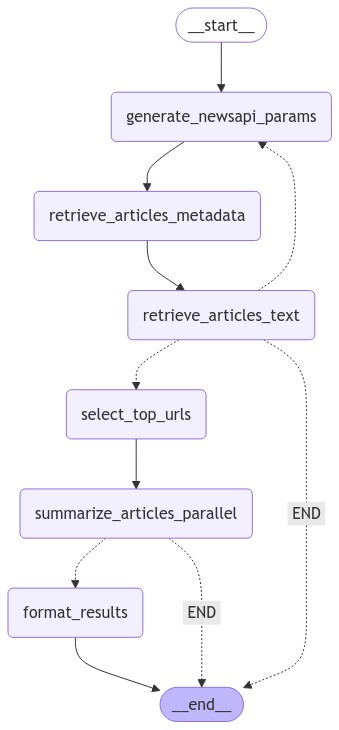

In [462]:
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Workflow Function

Define a function to run the workflow and display results.

In [463]:
async def run_workflow(query: str, num_searches_remaining: int = 10, num_articles_tldr: int = 3):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "news_query": query,
        "num_searches_remaining": num_searches_remaining,
        "newsapi_params": {},
        "past_searches": [],
        "articles_metadata": [],
        "scraped_urls": [],
        "num_articles_tldr": num_articles_tldr,
        "potential_articles": [],
        "tldr_articles": [],
        "formatted_results": "No articles with text found."
    }
    try:
        result = await app.ainvoke(initial_state)
        
        return result["formatted_results"]
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None
    

## Execute Workflow

Run the workflow with a sample query.

In [464]:
query = "How is Tesla doing?"
print(await run_workflow(query, num_articles_tldr=3))

Here are the top 3 articles based on search terms:
Tesla news

Elon Musk unveils $30,000 Tesla Cybercab with 2026 production, but details lacking  
https://financialpost.com/commodities/energy/electric-vehicles/elon-musk-unveils-tesla-cybercab-2026-production  
* Elon Musk introduced the Cybercab, a two-seat self-driving taxi prototype, at a Tesla event in California.  
* The Cybercab is expected to start production in 2026, with a projected cost of around $30,000.  
* Investors expressed disappointment due to the lack of detailed information on Tesla's plans for fully autonomous vehicles.  
* Musk did not address important topics such as regulatory challenges or fleet management for Cybercabs.  
* Tesla shares fell by 6.9% following the event, as many investors anticipated more concrete timelines and details.  
* The Cybercab features an innovative design with upward-opening doors and lacks traditional controls like a steering wheel.  
* Musk's presentation included a Robovan concept 